#  Project : CabEdge

## Cleaning : Writing a cleaning function to clean individual month Databases

In [2]:
import pandas as pd
import numpy as np
import import_ipynb

In [2]:
import cabedge_utils
import glob

importing Jupyter notebook from cabedge_utils.ipynb


In [14]:
def extract_day(df):
    timestamp = str(df)
    return timestamp[8:10]

In [15]:
def extract_hour(df):
    timestamp = str(df)
    return timestamp[11:13]

In [3]:
def cleaning(df):
    
    print('Shape of the database before Cleaning: ',df.shape)
    
    """Drop all unwanted columns which are not required for this project"""
    columns = df.columns
    del_columns = ['VendorID','congestion_surcharge','passenger_count','RatecodeID','store_and_fwd_flag','payment_type','extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge']
    for col in columns:
        if col in del_columns:
            df = df.drop(columns=[col])
    
    """ First PULocationID and DOLocationID should be within 1 and 263 both inclusive"""
    df = df.drop(df[(df['PULocationID'] > 263) | (df['DOLocationID'] > 263)].index)
    df = df.drop(df[(df['PULocationID'] < 1) | (df['DOLocationID'] < 1)].index)
    
    """ Fare Amount should not be less than 2.5$(basefare) and should not be greater than 200$(Outlier) """
    df = df.drop(df[(df['fare_amount'] < 2.5) | (df['fare_amount'] > 200)  ].index)
    
    
    """Trip distance cannot be less than 0.1 or greater than 100 miles(Outliers) """
    df = df.drop(df[(df['trip_distance'] < 0.1) | (df['trip_distance'] > 100)].index)
    
    print('Shape of the database after Cleaning: ',df.shape)
    
    print('------------------------------------------------------------')
    print('----------------FIRST CLEANING COMPLETED--------------------')
    print('------------------------------------------------------------')
    
    return df
    

## Feature Engineering

In [4]:
def feature_engineering(df):
    
    """Calling already defined function in cabedge_utils to extract pickup and dropoff date and time"""
    df['pickup_date'] = df['tpep_pickup_datetime'].apply(cabedge_utils.time_to_date)
    df['pickup_time'] = df['tpep_pickup_datetime'].apply(cabedge_utils.time_to_time)
    
    df['dropoff_date'] = df['tpep_dropoff_datetime'].apply(cabedge_utils.time_to_date)
    df['dropoff_time'] = df['tpep_dropoff_datetime'].apply(cabedge_utils.time_to_time)
    
    """ Calling already defined function in cabedge_utils to extract hour,day.month,year"""
    df['pickup_hour'] = df['pickup_time'].apply(cabedge_utils.time_to_hour)
    df['pickup_day'] = df['pickup_date'].apply(cabedge_utils.date_to_day)
    df['pickup_month'] = df['pickup_date'].apply(cabedge_utils.date_to_month)
    df['pickup_year'] = df['pickup_date'].apply(cabedge_utils.date_to_year)
    
    df['dropoff_hour'] = df['dropoff_time'].apply(cabedge_utils.time_to_hour)
    df['dropoff_day'] = df['dropoff_date'].apply(cabedge_utils.date_to_day)
    df['dropoff_month'] = df['dropoff_date'].apply(cabedge_utils.date_to_month)
    df['dropoff_year'] = df['dropoff_date'].apply(cabedge_utils.date_to_year)
    
    df = df.drop(columns=['pickup_date','pickup_time','dropoff_date','dropoff_time'])
    
    print('------------------------------------------------------------')
    print('----------------FEATURE ENGINEERING COMPLETED--------------')
    print('------------------------------------------------------------')
    
    return df

In [5]:
def cleaning_fe(df,year,month):
        
    df = df.drop(df[(df['pickup_year'] != year)].index)
    df = df.drop(df[(df['dropoff_year'] != year)].index)
                 
    df = df.drop(df[(df['pickup_month'] != month)].index)
    df = df.drop(df[(df['dropoff_month'] != month)].index)
    
   
    print('--------CLEANING AFTER FEATURE ENGINEERING COMPLETED--------')
    print('------------------------------------------------------------')
    return df
    

In [6]:
month_day = {'01' : 31,'02': 28, '03':31,'04':30,'05':31,'06':30,'07':31,'08':31,'09':30,'10':31,'11':30,'12':31}

def pickup_database(df):
    #Grouping and subgrouping based 
    pickup_group = pd.DataFrame(df.groupby(by=['PULocationID','pickup_year','pickup_month','pickup_day','pickup_hour'])['PULocationID'].count())
    pickup_group = pickup_group.rename(columns={'PULocationID':'Count'}).reset_index()
    
    datetime = []
    year = pickup_group['pickup_year'].unique()[0]
    month = pickup_group['pickup_month'].unique()[0]
    start_str = year+'-'+month+'-'+'01'
    
    #Converting to datetime format
    
    for row in pickup_group.index:
        datetime_str = year+'-'+ month + '-' +pickup_group.iloc[row,3] + ' '+ pickup_group.iloc[row,4] + ':00:00'
        datetime.append(datetime_str)
    
    print(datetime[0])
    pickup_group['datetime'] = datetime
    pickup_group['datetime'] = pd.to_datetime(pickup_group['datetime'])
    
    #Logic for setting the count of rides to '0' for the hour where there were no rides for a particular zone
    reference_df = pd.DataFrame({'datetime': pd.date_range(start=start_str, periods=month_day[month]*24, freq='H'), 'Score': 0})
    
    pickup_merge = pd.DataFrame(columns=['PULocationID', 'pickup_year', 'pickup_month', 'pickup_day',
       'pickup_hour', 'Count', 'datetime'])
    
    for location in range(1,264):
        filtered_df = pickup_group[pickup_group['PULocationID'] == location]
        merge_df = pd.merge(filtered_df,reference_df,on='datetime',how='outer')
        
        merge_df=merge_df.drop(columns=['Score'])
        merge_df['PULocationID']=merge_df['PULocationID'].fillna(location)
        merge_df['pickup_year'] = merge_df['pickup_year'].fillna(year)
        merge_df['pickup_month'] = merge_df['pickup_month'].fillna(month)
        merge_df['pickup_day'] = merge_df['datetime'].apply(extract_day)
        merge_df['pickup_hour'] = merge_df['datetime'].apply(extract_hour)
        merge_df['Count'] = merge_df['Count'].fillna(0)
        
        pickup_merge = pd.concat([pickup_merge,merge_df],ignore_index=True)
#   

    print('------------------------------------------------------------')
    print('----------------PICK UP DATABASE CREATED--------------')
    print('------------------------------------------------------------')
    return pickup_merge


def dropoff_database(df):
    dropoff_group = pd.DataFrame(df.groupby(by=['DOLocationID','dropoff_year','dropoff_month','dropoff_day','dropoff_hour'])['DOLocationID'].count())
    dropoff_group = dropoff_group.rename(columns={'DOLocationID':'Count'}).reset_index()
    
    datetime = []
    year = dropoff_group['dropoff_year'].unique()[0]
    month = dropoff_group['dropoff_month'].unique()[0]
    start_str = year+'-'+month+'-'+'01'
    
    for row in dropoff_group.index:
        datetime_str = year+'-'+ month + '-' +dropoff_group.iloc[row,3] + ' '+ dropoff_group.iloc[row,4] + ':00:00'
        datetime.append(datetime_str)
    
    print(datetime[0])
    dropoff_group['datetime'] = datetime
    dropoff_group['datetime'] = pd.to_datetime(dropoff_group['datetime'])

    #Logic for setting the count of rides to '0' for the hour where there were no rides for a particular zone
    reference_df = pd.DataFrame({'datetime': pd.date_range(start=start_str, periods=month_day[month]*24, freq='H'), 'Score': 0})
    
    dropoff_merge = pd.DataFrame(columns=['DOLocationID', 'dropoff_year', 'dropoff_month', 'dropoff_day',
       'dropoff_hour', 'Count', 'datetime'])
    
    for location in range(1,264):
        filtered_df = dropoff_group[dropoff_group['DOLocationID'] == location]
        merge_df = pd.merge(filtered_df,reference_df,on='datetime',how='outer')
        
        merge_df=merge_df.drop(columns=['Score'])
        merge_df['DOLocationID']=merge_df['DOLocationID'].fillna(location)
        merge_df['dropoff_year'] = merge_df['dropoff_year'].fillna(year)
        merge_df['dropoff_month'] = merge_df['dropoff_month'].fillna(month)
        merge_df['dropoff_day'] = merge_df['datetime'].apply(extract_day)
        merge_df['dropoff_hour'] = merge_df['datetime'].apply(extract_hour)
        merge_df['Count'] = merge_df['Count'].fillna(0)
        
        dropoff_merge = pd.concat([dropoff_merge,merge_df],ignore_index=True)
    
    print('------------------------------------------------------------')
    print('----------------DROP OFF DATABASE CREATED-------------------')
    print('------------------------------------------------------------')
    return dropoff_merge  
    

In [7]:
def monthly_weather_ride_pickup(df,weather):
    empty_df = pd.DataFrame()
    for location in range(1,264):
        filtered_df = df[df['PULocationID'] == location]
        merge_df= pd.merge(weather,filtered_df,on='datetime',how='inner')
        empty_df=pd.concat([empty_df,merge_df],ignore_index=True)
    print(empty_df.shape)
   
    print('---------------MERGING WEATHER DATA COMPLETED--------------')
    
    return empty_df

In [8]:
def monthly_weather_ride_dropoff(df,weather):
    empty_df = pd.DataFrame()
    for location in range(1,264):
        filtered_df = df[df['DOLocationID'] == location]
        merge_df= pd.merge(weather,filtered_df,on='datetime',how='inner')
        empty_df=pd.concat([empty_df,merge_df],ignore_index=True)
    print(empty_df.shape)
    
    print('---------------MERGING WEATHER DATA COMPLETED--------------')
    return empty_df

In [9]:
def all_in_one(df):
    df = cleaning(df)
    df = feature_engineering(df)
    month = df['pickup_month'].unique()[0]
    year = df['pickup_year'].unique()[0]
    df = cleaning_fe(df,year,month)
    pickup_2019 = pickup_database(df)
    dropoff_2019 = dropoff_database(df)
    weather_utc = pd.read_csv('C:/Users/Arinab/Desktop/DataScience/capstone/Processed-dataframe/weather_data_final.csv')
    weather = weather_utc[['datetime','apparentTemperature','summary','windSpeed']]
    weather['datetime'] = pd.to_datetime(weather['datetime'])
    
    weather_pickup_2019 = monthly_weather_ride_pickup(pickup_2019,weather)
    weather_dropoff_2019 = monthly_weather_ride_dropoff(dropoff_2019,weather)
    
    return weather_pickup_2019,weather_dropoff_2019
    

In [4]:
# df = pd.read_csv('C:/Users/Arinab/Desktop/DataScience/capstone/Trips/yellow_tripdata_2018-12.csv')

In [110]:
weather_pickup_dec_2018, weather_dropoff_dec_2018 = all_in_one(df)

Shape of the database before Cleaning:  (8173231, 17)
Shape of the database after Cleaning:  (7918146, 7)
------------------------------------------------------------
----------------FIRST CLEANING COMPLETED--------------------
------------------------------------------------------------
------------------------------------------------------------
----------------FEATURE ENGINEERING COMPLETED--------------
------------------------------------------------------------
--------CLEANING AFTER FEATURE ENGINEERING COMPLETED--------
------------------------------------------------------------
2018-12-01 15:00:00
------------------------------------------------------------
----------------PICK UP DATABASE CREATED--------------
------------------------------------------------------------
2018-12-01 01:00:00
------------------------------------------------------------
----------------DROP OFF DATABASE CREATED-------------------
------------------------------------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


(195672, 10)
---------------MERGING WEATHER DATA COMPLETED--------------
(195672, 10)
---------------MERGING WEATHER DATA COMPLETED--------------


In [116]:
weather_pickup_dec_2018.to_csv('C:/Users/Arinab/Desktop/DataScience/capstone/Processed-dataframe/weather_pickup_dec_2018.csv')

In [117]:
weather_dropoff_dec_2018.to_csv('C:/Users/Arinab/Desktop/DataScience/capstone/Processed-dataframe/weather_dropoff_dec_2018.csv')

In [99]:
weather_pickup_oct_2018.shape

(195409, 10)

In [100]:
weather_dropoff_oct_2018.shape

(195409, 10)

In [115]:
weather_pickup_dec_2018.head()

,datetime,apparentTemperature,summary,windSpeed,PULocationID,pickup_year,pickup_month,pickup_day,pickup_hour,Count
0,2018-12-01 00:00:00,36.75,Partly Cloudy,1.57,1.0,2018,12,01,00,0.0
1,2018-12-01 01:00:00,37.50,Partly Cloudy,1.27,1.0,2018,12,01,01,0.0
2,2018-12-01 02:00:00,38.59,Partly Cloudy,1.20,1.0,2018,12,01,02,0.0
3,2018-12-01 03:00:00,40.04,Partly Cloudy,1.87,1.0,2018,12,01,03,0.0
4,2018-12-01 04:00:00,41.02,Mostly Cloudy,2.46,1.0,2018,12,01,04,0.0


In [114]:
weather_pickup_dec_2018.tail()

,datetime,apparentTemperature,summary,windSpeed,PULocationID,pickup_year,pickup_month,pickup_day,pickup_hour,Count
195667,2018-12-31 19:00:00,31.17,Mostly Cloudy,1.53,263.0,2018,12,31,19,483.0
195668,2018-12-31 20:00:00,31.69,Mostly Cloudy,1.54,263.0,2018,12,31,20,456.0
195669,2018-12-31 21:00:00,31.59,Mostly Cloudy,1.54,263.0,2018,12,31,21,439.0
195670,2018-12-31 22:00:00,31.23,Mostly Cloudy,1.40,263.0,2018,12,31,22,313.0
195671,2018-12-31 23:00:00,32.56,Mostly Cloudy,1.65,263.0,2018,12,31,23,193.0


In [113]:
weather_dropoff_dec_2018.head()

,datetime,apparentTemperature,summary,windSpeed,DOLocationID,dropoff_year,dropoff_month,dropoff_day,dropoff_hour,Count
0,2018-12-01 00:00:00,36.75,Partly Cloudy,1.57,1.0,2018,12,01,00,0.0
1,2018-12-01 01:00:00,37.50,Partly Cloudy,1.27,1.0,2018,12,01,01,1.0
2,2018-12-01 02:00:00,38.59,Partly Cloudy,1.20,1.0,2018,12,01,02,1.0
3,2018-12-01 03:00:00,40.04,Partly Cloudy,1.87,1.0,2018,12,01,03,3.0
4,2018-12-01 04:00:00,41.02,Mostly Cloudy,2.46,1.0,2018,12,01,04,6.0


In [111]:
weather_dropoff_dec_2018.tail()

,datetime,apparentTemperature,summary,windSpeed,DOLocationID,dropoff_year,dropoff_month,dropoff_day,dropoff_hour,Count
195667,2018-12-31 19:00:00,31.17,Mostly Cloudy,1.53,263.0,2018,12,31,19,434.0
195668,2018-12-31 20:00:00,31.69,Mostly Cloudy,1.54,263.0,2018,12,31,20,363.0
195669,2018-12-31 21:00:00,31.59,Mostly Cloudy,1.54,263.0,2018,12,31,21,392.0
195670,2018-12-31 22:00:00,31.23,Mostly Cloudy,1.40,263.0,2018,12,31,22,291.0
195671,2018-12-31 23:00:00,32.56,Mostly Cloudy,1.65,263.0,2018,12,31,23,231.0


In [37]:
weather_pickup_apr_2018['datetime'].min()

Timestamp('2018-04-01 00:00:00')

In [38]:
weather_pickup_apr_2018['datetime'].max()

Timestamp('2018-04-30 23:00:00')

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

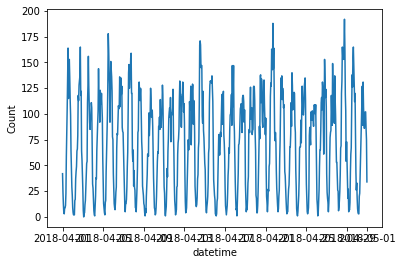

In [58]:
sns.lineplot(x='datetime',y='Count',data=weather_pickup_apr_2018[weather_pickup_apr_2018['PULocationID']==261] )

## Read all the pickup and dropoff files and create one single frame each for pickup and dropoff 

### Pickup Frame creation

In [11]:
path = r'C:\Users\Arinab\Desktop\DataScience\capstone\Processed-dataframe\pickup-2018' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

pick_frame = pd.concat(li, axis=0, ignore_index=True)

In [12]:
pick_frame.shape

(2303880, 11)

In [13]:
pick_frame.head()

,Unnamed: 0,datetime,apparentTemperature,summary,windSpeed,PULocationID,pickup_year,pickup_month,pickup_day,pickup_hour,Count
0,0,2018-04-01 00:00:00,40.42,Clear,3.27,1.0,2018,4,1,0,0.0
1,1,2018-04-01 01:00:00,45.16,Clear,2.28,1.0,2018,4,1,1,0.0
2,2,2018-04-01 02:00:00,48.38,Clear,1.34,1.0,2018,4,1,2,0.0
3,3,2018-04-01 02:00:00,51.37,Clear,1.68,1.0,2018,4,1,2,0.0
4,4,2018-04-01 03:00:00,53.91,Clear,2.96,1.0,2018,4,1,3,0.0


In [14]:
print(pick_frame['pickup_month'].unique())
print(pick_frame['pickup_month'].nunique())

[ 4  8 12  2  1  7  6  3  5 11 10  9]
12


In [15]:
print(pick_frame['pickup_hour'].unique())
print(pick_frame['pickup_hour'].nunique())

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
24


In [16]:
print(pick_frame['pickup_day'].unique())
print(pick_frame['pickup_day'].nunique())

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
31


In [17]:
pick_frame.drop(columns=['Unnamed: 0'],inplace=True)

In [19]:
pick_frame.head()

,datetime,apparentTemperature,summary,windSpeed,PULocationID,pickup_year,pickup_month,pickup_day,pickup_hour,Count
0,2018-04-01 00:00:00,40.42,Clear,3.27,1.0,2018,4,1,0,0.0
1,2018-04-01 01:00:00,45.16,Clear,2.28,1.0,2018,4,1,1,0.0
2,2018-04-01 02:00:00,48.38,Clear,1.34,1.0,2018,4,1,2,0.0
3,2018-04-01 02:00:00,51.37,Clear,1.68,1.0,2018,4,1,2,0.0
4,2018-04-01 03:00:00,53.91,Clear,2.96,1.0,2018,4,1,3,0.0


In [22]:
pick_frame.to_csv('C:/Users/Arinab/Desktop/DataScience/capstone/Processed-dataframe/complete_pickup_2018.csv')

### Dropoff Frame Creation

In [23]:
path = r'C:\Users\Arinab\Desktop\DataScience\capstone\Processed-dataframe\dropoff-2018' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

drop_frame = pd.concat(li, axis=0, ignore_index=True)

In [24]:
drop_frame.shape

(2303880, 11)

In [27]:
drop_frame.head()

,datetime,apparentTemperature,summary,windSpeed,DOLocationID,dropoff_year,dropoff_month,dropoff_day,dropoff_hour,Count
0,2018-04-01 00:00:00,40.42,Clear,3.27,1.0,2018,4,1,0,0.0
1,2018-04-01 01:00:00,45.16,Clear,2.28,1.0,2018,4,1,1,0.0
2,2018-04-01 02:00:00,48.38,Clear,1.34,1.0,2018,4,1,2,2.0
3,2018-04-01 02:00:00,51.37,Clear,1.68,1.0,2018,4,1,2,2.0
4,2018-04-01 03:00:00,53.91,Clear,2.96,1.0,2018,4,1,3,5.0


In [26]:
drop_frame.drop(columns=['Unnamed: 0'],inplace=True)

In [29]:
print(drop_frame['dropoff_month'].unique())
print(drop_frame['dropoff_month'].nunique())

[ 4  8 12  2  1  7  6  3  5 11 10  9]
12


In [30]:
print(drop_frame['dropoff_day'].unique())
print(drop_frame['dropoff_day'].nunique())

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
31


In [31]:
print(drop_frame['dropoff_hour'].unique())
print(drop_frame['dropoff_hour'].nunique())

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
24


### Zone with the Max number of pickups 

In [56]:
# drop_frame.to_csv('C:/Users/Arinab/Desktop/DataScience/capstone/Processed-dataframe/complete_dropoff_2018.csv')

In [59]:
total_pickup_year=pd.DataFrame(pick_frame.groupby(['PULocationID'])['Count'].sum()).reset_index().sort_values(by='Count',ascending=False)

In [62]:
pd.DataFrame(pick_frame.groupby(['PULocationID'])['Count'].sum()).reset_index().sort_values(by='Count',ascending=False).head()

,PULocationID,Count
236,237.0,4235975.0
160,161.0,3919941.0
235,236.0,3843504.0
161,162.0,3583091.0
185,186.0,3462358.0


### Zone with the Max number of dropoff 

In [57]:
pd.DataFrame(drop_frame.groupby(['DOLocationID'])['Count'].sum()).reset_index().sort_values(by='Count',ascending=False).head(10)

,DOLocationID,Count
235,236.0,3955820.0
160,161.0,3870763.0
236,237.0,3697608.0
169,170.0,3253825.0
229,230.0,3144267.0
161,162.0,3131831.0
47,48.0,2783284.0
233,234.0,2751982.0
141,142.0,2728885.0
185,186.0,2668357.0
